# Generating Zarr data cubes with Sentinel Hub Batch API

In this notebook, we will first create Zarr data cube using Sentinel Hub Batch Processing API. The results (zarr group) will be first be stored on S3 and then we will download them and read them into xarray dataset. 

You will need an EDC Sentinel Hub Enterprise subscription to execute this notebook as well as your own object storage (S3).

## Imports and authentication

First, let's import all pacakges we will be using and authenticate at Sentinel Hub.

In [4]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import os
import fsspec
import xarray as xr

# Your client credentials
client_id = os.environ["SH_CLIENT_ID"]
client_secret = os.environ["SH_CLIENT_SECRET"]

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_secret=client_secret)

## Create Batch Processing request to calculate maximum NDVI in for three months

This example is taken from the official Sentinel Hub documentation: https://docs.sentinel-hub.com/api/latest/api/batch/examples/#option-2-zarr-format-output. To run it, please replace a placeholder `<your-bucket>` with your value (e.g. "s3://my-bucket/batch-zarr-demo"). Your object storage has to be configured as described here: https://docs.sentinel-hub.com/api/latest/api/batch/#aws-bucket-settings

The example requests all Sentinel-2 data acquired between April 2019 and June 2019 for the selected AOI, which is an island of Corsica in this example. The request returns the maximum value of NDVI in this period as well as values of bands 4 and 8 based on which the max NDVI was calculated. The output is stored on selected S3 storage in a Zarr format.

In [ ]:
url = "https://services.sentinel-hub.com/api/v1/batch/process"

evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B04", "B08"]
            }],
            output: [{
                id: "maxNDVI",
                sampleType: "FLOAT32",
                bands: 1
            },
            {
                id: "band04",
                sampleType: "UINT16",
                bands: 1
            },
            {
                id: "band08",
                sampleType: "UINT16",
                bands: 1
            }],
            mosaicking: Mosaicking.ORBIT
        }
    }

    function calcNDVI(sample) {
        var denom = sample.B04 + sample.B08
        return ((denom != 0) ? (sample.B08 - sample.B04) / denom : 0.0)
    }

    function evaluatePixel(samples) {
        var maxNDVI = 0
        var band04 = 0
        var band08 = 0
        for (var i = 0; i < samples.length; i++) {
            var ndvi = calcNDVI(samples[i])
            if (ndvi > maxNDVI){
                maxNDVI = ndvi
                band04 = samples[i].B04
                band08 = samples[i].B08
            }
        }

        return {
            maxNDVI: [maxNDVI],
            band04: [band04],
            band08: [band08]
        }
    }
"""

payload = {
    "processRequest": {
        "input": {
            "bounds": {
                "bbox": [
                    8.44,
                    41.31,
                    9.66,
                    43.1
                ],
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                }
            },
            "data": [{
                "dataFilter": {
                    "timeRange": {
                        "from": "2019-04-01T00:00:00Z",
                        "to": "2019-06-30T00:00:00Z"
                    },
                "maxCloudCoverage": 70.0
                },
                "type": "sentinel-2-l2a"
            }]
        },
        "output": {
            "responses": [{
                "identifier": "band08",
                "format": {
                    "type": "zarr/array"
                }
            },
                {
                "identifier": "band04",
                "format": {
                    "type": "zarr/array"
                }
            },
                {
                "identifier": "maxNDVI",
                "format": {
                    "type": "zarr/array"
                }
            }]
        },
        "evalscript": evalscript
    },
    "tilingGrid": {
        "id": 6,
        "resolution": 100.0
    },
    "zarrOutput": {
        "path": "<your-bucket>/<requestId>",
        "group": {
            "zarr_format": 2
        },
        "arrayParameters": {
            "dtype": "<u2",
            "order": "C",
            "chunks": [1, 1000, 1000],
            "fill_value": 0
        },
        "arrayOverrides": {
            "maxNDVI": {
                "dtype": "<f4",
                "fill_value": "NaN"
            },
        }
    },
    "description": "Max NDVI over Corsica with Zarr format output"
}

headers = {
  'Content-Type': 'application/json'
}

response = oauth.request("POST", url, headers=headers, json = payload)

From the response, we will extract a request id and store it in a separate variable:

In [3]:
batch_request_id = response.json()['id']
batch_request_id

'9920066c-5336-4129-9e49-583dd6088ac3'

We could request an analysis of the batch request in order to ensure that everything will run smoothly. However, to shorten the process for this demo, we will simply request start of the processing:

In [4]:
# Start processing
url = f"https://services.sentinel-hub.com/api/v1/batch/process/{batch_request_id}/start"

response = oauth.request("POST", url)

response.status_code

204

Now we have to wait until the processing is DONE. We can check the status of the request with running:

In [10]:
# Check status
url = f"https://services.sentinel-hub.com/api/v1/batch/process/{batch_request_id}"

response = oauth.request("GET", url)

response.json()["status"]

'DONE'

The processing is DONE and the results are available in my object storage as shown below. Note that the folder name is batch request id, since we used a placeholder `<requestId>` in the `path` parameter earlier.

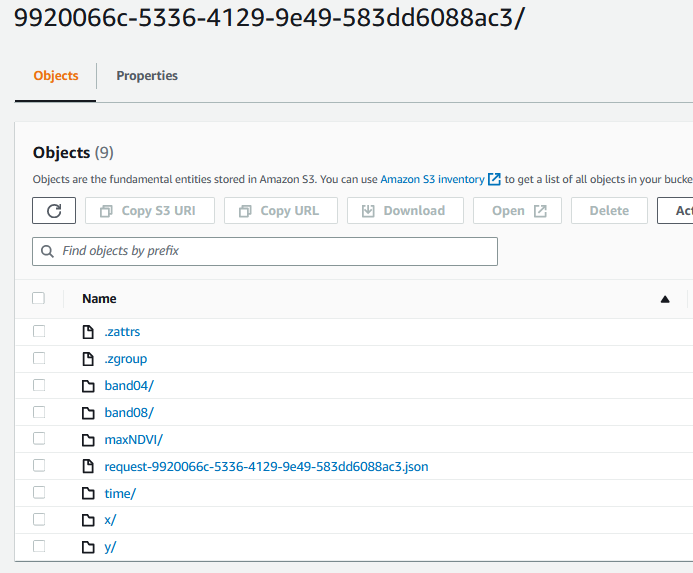

## Explore the results with xarray

We can now download the results and store them in the `./results` folder. Note that you will have to set up your AWS credentials correctly in order to execute this command. 

In [7]:
!aws s3 cp <your-bucket>/9920066c-5336-4129-9e49-583dd6088ac3 ./results --recursive 

Completed 460 Bytes/23.3 MiB (1.6 KiB/s) with 36 file(s) remaining
Completed 483 Bytes/23.3 MiB (1.7 KiB/s) with 36 file(s) remaining
download: s3://anja-sh-testing/batch-zarr-demo/9920066c-5336-4129-9e49-583dd6088ac3/.zattrs to results\.zattrs
Completed 483 Bytes/23.3 MiB (1.7 KiB/s) with 35 file(s) remaining
download: s3://anja-sh-testing/batch-zarr-demo/9920066c-5336-4129-9e49-583dd6088ac3/.zgroup to results\.zgroup
Completed 483 Bytes/23.3 MiB (1.7 KiB/s) with 34 file(s) remaining
Completed 798 Bytes/23.3 MiB (2.5 KiB/s) with 34 file(s) remaining
Completed 846 Bytes/23.3 MiB (2.7 KiB/s) with 34 file(s) remaining
download: s3://anja-sh-testing/batch-zarr-demo/9920066c-5336-4129-9e49-583dd6088ac3/band04/.zarray to results\band04\.zarray
Completed 846 Bytes/23.3 MiB (2.7 KiB/s) with 33 file(s) remaining
download: s3://anja-sh-testing/batch-zarr-demo/9920066c-5336-4129-9e49-583dd6088ac3/band04/.zattrs to results\band04\.zattrs
Completed 846 Bytes/23.3 MiB (2.7 KiB/s) with 32 file(s) re

Completed 10.9 MiB/23.3 MiB (6.8 MiB/s) with 5 file(s) remaining
Completed 11.2 MiB/23.3 MiB (6.9 MiB/s) with 5 file(s) remaining
Completed 11.4 MiB/23.3 MiB (6.8 MiB/s) with 5 file(s) remaining
Completed 11.7 MiB/23.3 MiB (6.9 MiB/s) with 5 file(s) remaining
Completed 11.9 MiB/23.3 MiB (7.0 MiB/s) with 5 file(s) remaining
Completed 12.2 MiB/23.3 MiB (7.1 MiB/s) with 5 file(s) remaining
Completed 12.4 MiB/23.3 MiB (7.1 MiB/s) with 5 file(s) remaining
Completed 12.7 MiB/23.3 MiB (7.1 MiB/s) with 5 file(s) remaining
Completed 12.9 MiB/23.3 MiB (7.2 MiB/s) with 5 file(s) remaining
Completed 13.2 MiB/23.3 MiB (7.2 MiB/s) with 5 file(s) remaining
Completed 13.4 MiB/23.3 MiB (7.2 MiB/s) with 5 file(s) remaining
Completed 13.7 MiB/23.3 MiB (7.3 MiB/s) with 5 file(s) remaining
Completed 13.9 MiB/23.3 MiB (7.3 MiB/s) with 5 file(s) remaining
Completed 14.2 MiB/23.3 MiB (7.4 MiB/s) with 5 file(s) remaining
Completed 14.4 MiB/23.3 MiB (7.4 MiB/s) with 5 file(s) remaining
Completed 14.7 MiB/23.3 M

We can now open and explore the date with xarray:

In [5]:
cube_before = xr.open_zarr("./results")
cube_before

<xarray.Dataset>
Dimensions:  (time: 1, x: 2000, y: 3000)
Coordinates:
  * time     (time) datetime64[ns] 2019-04-01
  * x        (x) float64 4.1e+06 4.1e+06 4.1e+06 ... 4.3e+06 4.3e+06 4.3e+06
  * y        (y) float64 2.3e+06 2.3e+06 2.3e+06 2.3e+06 ... 2e+06 2e+06 2e+06
Data variables:
    band04   (time, y, x) float32 ...
    band08   (time, y, x) float32 ...
    maxNDVI  (time, y, x) float32 ...
Attributes:
    geospatial_lat_max:         2300000.0
    date_modified:              2022-11-21T11:47:57.644625Z
    geospatial_lat_units:       degrees_north
    time_coverage_end:          2019-06-30T00:00:00Z
    geospatial_lat_resolution:  100.0
    geospatial_lon_min:         4100000.0
    geospatial_lon_max:         4300000.0
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  100.0
    time_coverage_start:        2019-04-01T00:00:00Z
    geospatial_lat_min:         2000000.0

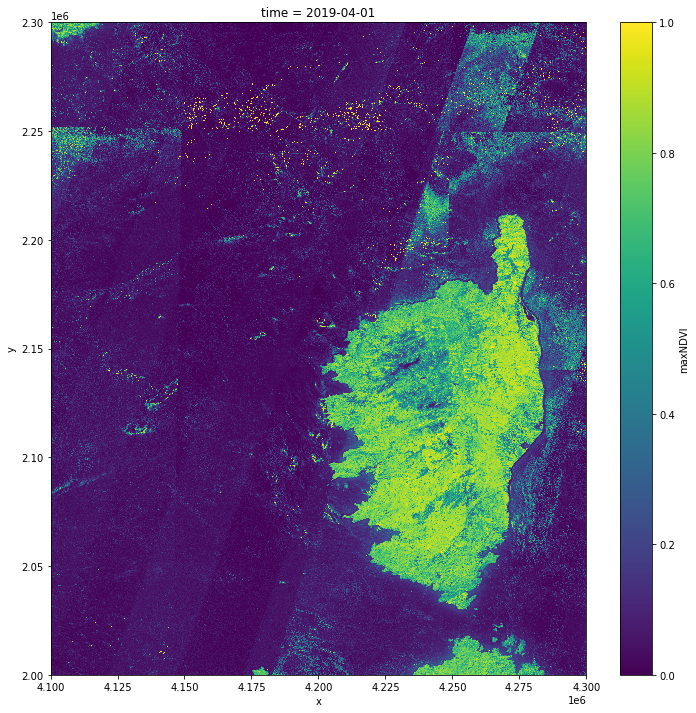

In [16]:
cube_before.maxNDVI.isel(time=0).plot(figsize=[12,12], vmax=1.0)

## Ingest results to Sentinel Hub with Zarr import API

The results can also be ingested back to the Sentinel Hub: 

In [26]:
collection = {
  'name': 'My Zarr Test Nov',
  's3Bucket': <your-bucket-name>,
  'path': f'<folder-in-your-bucket>/{batch_request_id}/',
  "crs":"http://www.opengis.net/def/crs/EPSG/0/3035"
}

response = oauth.post('https://services.sentinel-hub.com/api/v1/zarr/collections', json=collection)
response.raise_for_status()

This create a data collection. To get its id, run `response.json()["data"]["id"]`. Form here on, we can use all Sentinel Hub funcionalites when working with this data collection.